In [1]:
from imputationLibrary import forwardFilling, hotDeck, meanImputation, movingAverage, splineInterpolation, separate, randomSampleImputation
from imputationLibrary.util import util
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from tsmoothie.smoother import *
import matplotlib.pyplot as plt

In [2]:
INPUT = 'output/\CompleteWeeklyIndexes'

In [24]:
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)
df_test = df.loc['2015-01-02':] #Selecting test data
df_train = df.loc['2000-01-01':'2015-01-01'] #Selecting training data

In [25]:
### USE KALMAN FILTER TO SMOOTH ALL DATA (ONLY VISUALIZATION PURPOSE) ###

smoother_train = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother_train.smooth(df_train.T)

smoother_test = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365)
smoother_test.smooth(df_test.T)

<tsmoothie.smoother.KalmanSmoother>

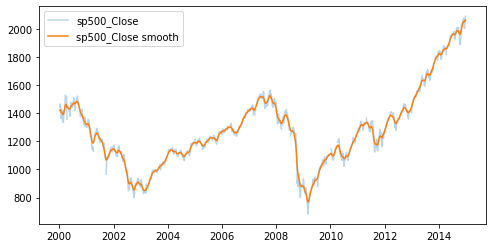

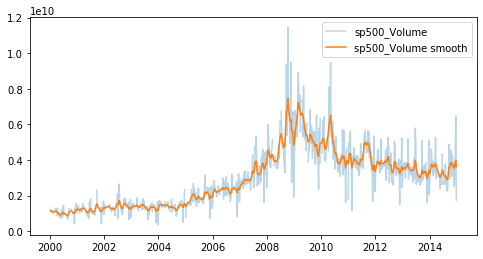

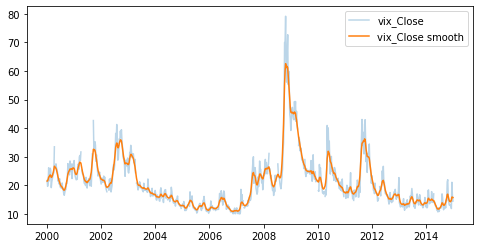

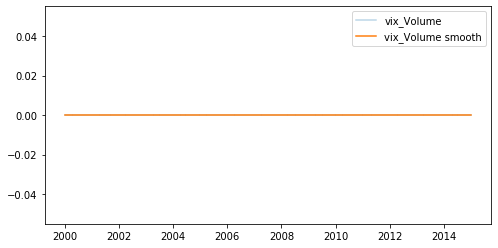

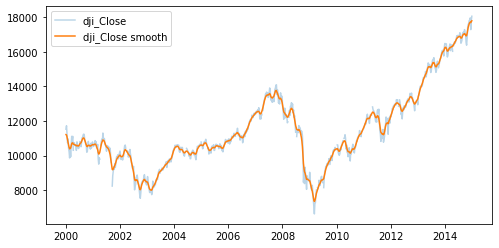

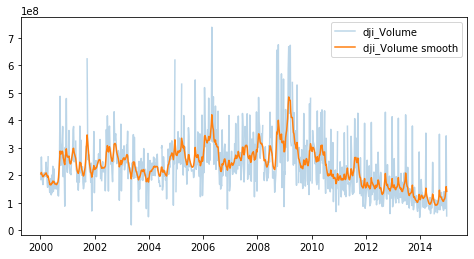

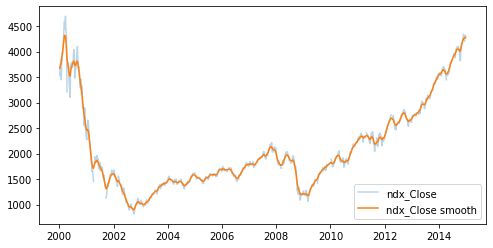

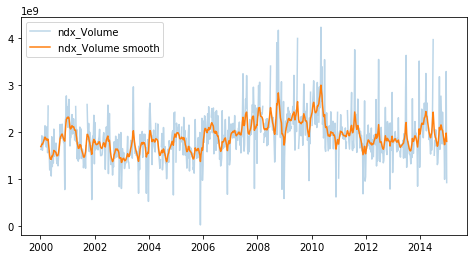

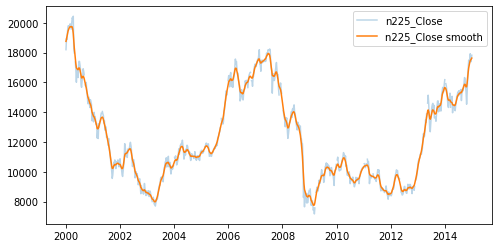

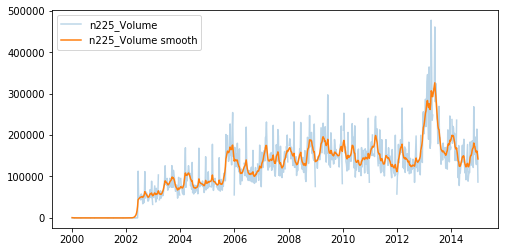

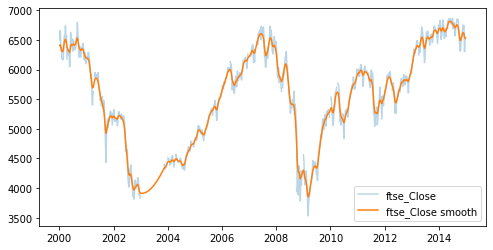

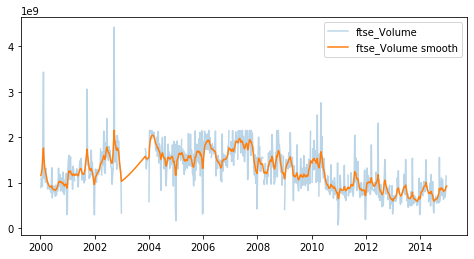

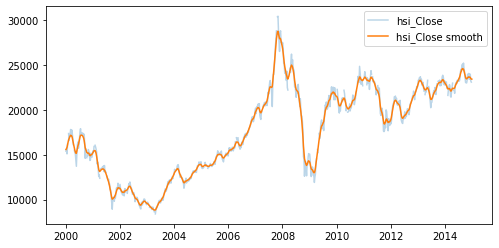

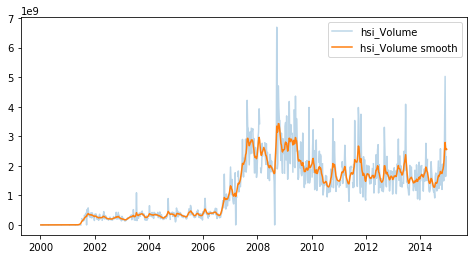

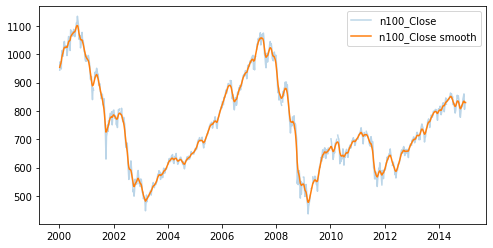

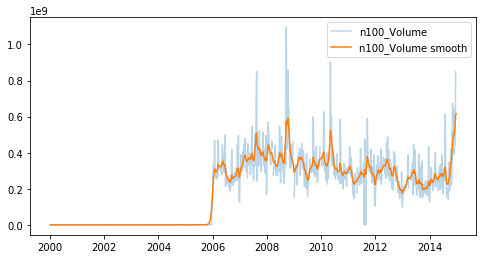

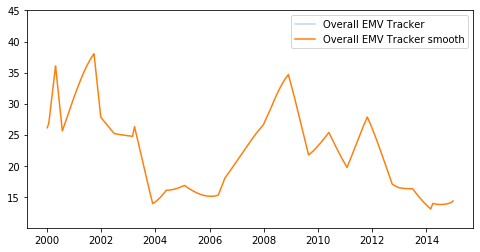

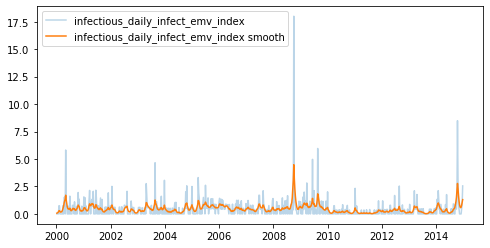

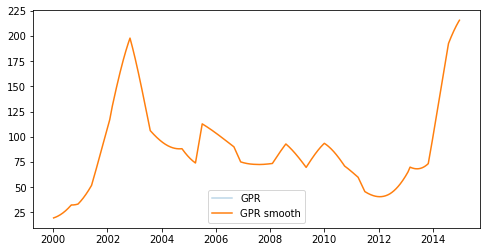

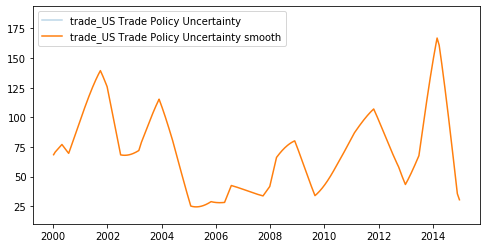

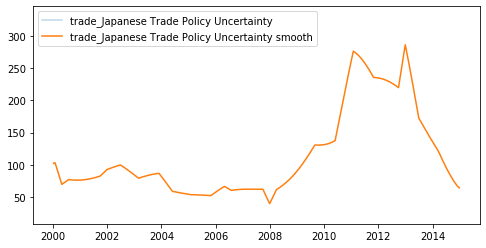

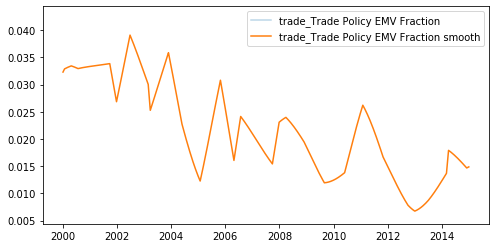

In [26]:
for i, name in enumerate(df_train.columns):
    plt.figure(figsize=(8,4))
    plt.plot(df_train.index, smoother_train.data[i], label=name, alpha=0.3)
    plt.plot(df_train.index, smoother_train.smooth_data[i], label=name+' smooth')
    plt.legend(); plt.show()

In [27]:
df_train = pd.DataFrame(data = smoother_train.data.T, index = df_train.index, columns= df_train.columns)
df_test = pd.DataFrame(data = smoother_test.data.T, index = df_test.index, columns= df_test.columns)

In [28]:
df_white_noise, df_seasonal, df_trended, df_trend_and_seasonal = separate.separate(df_train)

In [29]:
# infectious_daily_infect_emv_index, trade_US Trade Policy Uncertainty
df_white_noise.columns

Index(['vix_Volume', 'infectious_daily_infect_emv_index', 'GPR'], dtype='object')

In [30]:
df_seasonal.columns

Index(['trade_Trade Policy EMV Fraction'], dtype='object')

In [31]:
# sp500_Close, sp500_Volume, vix_Close, vix_Volume, 'dji_Close', 'dji_Volume', 'ndx_Close',
#       'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume',
#       'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume','trade_Trade Policy EMV Fraction'
df_trended.columns

Index(['sp500_Volume', 'Overall EMV Tracker'], dtype='object')

In [32]:
# GPR, trade_Japanese Trade Policy Uncertainty, trade_US Trade Policy Uncertainty
df_trend_and_seasonal.columns

Index(['sp500_Close', 'vix_Close', 'dji_Close', 'dji_Volume', 'ndx_Close',
       'ndx_Volume', 'n225_Close', 'n225_Volume', 'ftse_Close', 'ftse_Volume',
       'hsi_Close', 'hsi_Volume', 'n100_Close', 'n100_Volume',
       'trade_US Trade Policy Uncertainty',
       'trade_Japanese Trade Policy Uncertainty'],
      dtype='object')

In [33]:
df_seasonal_train, df_seasonal_test = randomSampleImputation.input(df.loc['2000-01-01':'2015-01-01', df_seasonal.columns], df.loc['2015-01-02':, df_seasonal.columns], sliding_window_size = 0.03)

C:\Users\silva\Anaconda3\envs\mestrado\lib\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [34]:
df_white_noise_train, df_white_noise_test =  meanImputation.input(df.loc['2000-01-01':'2015-01-01', df_white_noise.columns], df.loc['2015-01-02':, df_white_noise.columns])

In [35]:
df_trended_train, df_trended_test =  forwardFilling.input(df.loc['2000-01-01':'2015-01-01', df_trended.columns], df.loc['2015-01-02':, df_trended.columns])

In [36]:
df_trend_and_seasonal_train, df_trend_and_seasonal_test =  splineInterpolation.input(df.loc['2000-01-01':'2015-01-01', df_trend_and_seasonal.columns], df.loc['2015-01-02':, df_trend_and_seasonal.columns])

In [37]:
df_train = pd.concat([df_seasonal_train, df_white_noise_train, df_trended_train, df_trend_and_seasonal_train], axis=1, join='outer')

In [38]:
df_seasonal_test.index = df_white_noise_test.index

In [39]:
df_test = pd.concat([df_seasonal_test, df_white_noise_test, df_trended_test, df_trend_and_seasonal_test], axis=1, join='outer')

In [40]:
# Subsample para weekly

# Generating weekly sampled dataset
def generate_weekly(df, initial_friday):
    df_friday = initial_friday #datetime(2000,1,7)

    df_weekly = pd.DataFrame(columns = df.columns)
    
    while df_friday <= df.tail(1).index:
        df_weekly = df_weekly.append(df.loc[df_friday])
        df_friday+=timedelta(days=7)
    return df_weekly

In [41]:
df_train_weekly = generate_weekly(df_train, datetime(2000,1,7))
df_test_weekly = generate_weekly(df_test, datetime(2015,1,2))

In [42]:
df_test_weekly.shape

(272, 22)

In [43]:
df_test.head()

,trade_Trade Policy EMV Fraction,vix_Volume,infectious_daily_infect_emv_index,GPR,sp500_Volume,Overall EMV Tracker,sp500_Close,vix_Close,dji_Close,dji_Volume,...,n225_Close,n225_Volume,ftse_Close,ftse_Volume,hsi_Close,hsi_Volume,n100_Close,n100_Volume,trade_US Trade Policy Uncertainty,trade_Japanese Trade Policy Uncertainty
2015-01-02,0.025591,0.0,0.60,85.251996,2.708700e+09,13.894961,2058.199951,17.790001,17832.990234,76270000.0,...,16151.887114,131583.814456,6547.799805,367562200.0,23721.300781,1.801713e+09,835.969971,333050000.0,78.983339,95.095455
2015-01-09,0.011858,0.0,0.91,85.251996,3.364140e+09,13.894961,2044.810059,17.549999,17737.369141,93390000.0,...,17197.730469,155200.000000,6501.100098,738488500.0,23919.949219,2.334810e+09,824.390015,499788100.0,94.699999,103.076918
2015-01-16,0.032609,0.0,0.00,85.251996,4.056410e+09,13.894961,2019.420044,20.950001,17511.570313,140480000.0,...,16864.160156,171100.000000,6550.299805,805741900.0,24103.519531,1.716810e+09,862.820007,592856800.0,112.018246,111.837183
2015-01-23,0.009036,0.0,0.00,85.251996,3.573560e+09,13.894961,2051.820068,16.660000,17672.599609,97110000.0,...,17511.750000,132500.000000,6832.799805,839368300.0,24850.449219,2.375624e+09,911.729980,804870700.0,130.989976,121.401845
2015-01-30,0.034667,0.0,0.00,85.251996,4.568650e+09,13.894961,1994.989990,20.969999,17164.949219,168560000.0,...,17674.390625,173500.000000,6749.399902,799357300.0,24507.050781,1.438942e+09,906.280029,545062800.0,151.667082,131.796503


In [45]:
df_train_weekly.to_csv(r'output\/CompleteIndexesWeeklyTrainNatureKalman.csv', index = True)
df_test_weekly.to_csv(r'output\/CompleteIndexesWeeklyTestNatureKalman.csv', index = True)

In [46]:
df_train_complete.head()

NameError: name 'df_train_complete' is not defined

In [47]:
df_train.head()

,trade_Trade Policy EMV Fraction,vix_Volume,infectious_daily_infect_emv_index,GPR,sp500_Volume,Overall EMV Tracker,sp500_Close,vix_Close,dji_Close,dji_Volume,...,n225_Close,n225_Volume,ftse_Close,ftse_Volume,hsi_Close,hsi_Volume,n100_Close,n100_Volume,trade_US Trade Policy Uncertainty,trade_Japanese Trade Policy Uncertainty
2000-01-07,0.032609,0.0,0.00,85.251996,1.225200e+09,24.412899,1441.469971,21.719999,11522.559570,184900000.0,...,18193.410156,0.0,6504.799805,8.883060e+08,15405.629883,0.000000e+00,943.880005,0.0,57.446994,157.733980
2000-01-14,0.021951,0.0,0.00,85.251996,1.085900e+09,24.412899,1465.150024,19.660000,11722.980469,266830000.0,...,18956.550781,0.0,6658.200195,1.098626e+09,15542.230469,0.000000e+00,973.859985,0.0,62.929141,143.011572
2000-01-21,0.009036,0.0,0.00,85.251996,1.209800e+09,24.412899,1441.359985,20.820000,11251.709961,205840000.0,...,18878.089844,0.0,6346.299805,1.007934e+09,15108.410156,0.000000e+00,951.510010,0.0,67.740930,129.644248
2000-01-28,0.033573,0.0,0.00,85.251996,1.095800e+09,24.412899,1360.160034,26.139999,10738.870117,183090000.0,...,19434.779297,0.0,6375.600098,9.182270e+08,16185.940430,0.000000e+00,948.210022,0.0,71.914247,117.577146
2000-02-04,0.035821,0.0,0.75,85.251996,1.045100e+09,24.412899,1424.369995,21.540001,10963.799805,166590000.0,...,19763.130859,0.0,6185.000000,2.309287e+09,17304.019832,-1.829865e-32,1010.429993,0.0,75.480977,106.755401


In [48]:
df_train_complete['n100_Volume']

NameError: name 'df_train_complete' is not defined

In [41]:
df_train['n100_Volume']

2000-01-07    8.883060e+08
2000-01-14    1.098626e+09
2000-01-21    1.007934e+09
2000-01-28    9.182270e+08
2000-02-04    2.309287e+09
2000-02-11    3.433671e+09
2000-02-18    1.098726e+09
2000-02-25    1.181230e+09
2000-03-03    1.107792e+09
2000-03-10    1.005534e+09
2000-03-17    1.309177e+09
2000-03-24    1.088155e+09
2000-03-31    1.019644e+09
2000-04-07    8.574380e+08
2000-04-14    9.964510e+08
2000-04-21    9.922872e+08
2000-04-28    8.821750e+08
2000-05-05    8.452740e+08
2000-05-12    8.702520e+08
2000-05-19    9.370820e+08
2000-05-26    7.782430e+08
2000-06-02    1.324934e+09
2000-06-09    6.617660e+08
2000-06-16    8.108170e+08
2000-06-23    8.185850e+08
2000-06-30    9.252250e+08
2000-07-07    7.932810e+08
2000-07-14    8.260630e+08
2000-07-21    6.981530e+08
2000-07-28    9.470970e+08
                  ...     
2014-06-06    7.748665e+08
2014-06-13    6.406146e+08
2014-06-20    1.020446e+09
2014-06-27    5.169869e+08
2014-07-04    3.293635e+08
2014-07-11    5.331748e+08
2